# Imports and Data Loading

In [ ]:
# 1) Imports and Data Loading

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm


# ----------------------------------------------------------
# Load the "train.csv" data
# ----------------------------------------------------------
train_data = pd.read_csv('train.csv')

# Print out column names for reference
print("Columns in train.csv:")
print(train_data.columns)

# We'll pick a handful of numeric features and SalePrice.
train_data = train_data[['LotFrontage', 'LotArea', 'PoolArea',
                         'OverallQual', 'OverallCond', 'YearBuilt',
                         'GarageArea', 'YrSold', 'SalePrice']]

# Feature Selection: The selected features provide insights with respect to size,
# condition and amenities of the respective properties. Hence, we believe those
# features are key to predict the target variable price.

# Drop rows with missing data (simple approach)
train_data.dropna(inplace=True)
print("Shape after dropping NAs:", train_data.shape)

# Optional peek at the data
train_data.head()


Columns in train.csv:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

,LotFrontage,LotArea,PoolArea,OverallQual,OverallCond,YearBuilt,GarageArea,YrSold,SalePrice
0,65.0,8450,0,7,5,2003,548,2008,208500
1,80.0,9600,0,6,8,1976,460,2007,181500
2,68.0,11250,0,7,5,2001,608,2008,223500
3,60.0,9550,0,7,5,1915,642,2006,140000
4,84.0,14260,0,8,5,2000,836,2008,250000


# Train/Validation Split

In [ ]:
# 2) Train/Validation Split --> preparing data for training and testing

# We'll do an 80/20 split within train.csv to create internal train/val sets:
X_train_val = train_data.drop('SalePrice', axis=1).values  # all but SalePrice
y_train_val = train_data['SalePrice'].values               # target only

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

print("Shapes:")
print("  X_train_split:", X_train_split.shape)
print("  X_val_split:  ", X_val_split.shape)
print("  y_train_split:", y_train_split.shape)
print("  y_val_split:  ", y_val_split.shape)


Shapes:
  X_train_split: (960, 8)
  X_val_split:   (241, 8)
  y_train_split: (960,)
  y_val_split:   (241,)


# Feature Scaling

In [ ]:
# 3) Feature Scaling (MinMaxScaler)

scaler = MinMaxScaler()
X_train_split_scaled = scaler.fit_transform(X_train_split)  # fit on train split
X_val_split_scaled   = scaler.transform(X_val_split)        # transform val split

# prevents features with larger values from dominating the learning process


# PyTorch Dataset & DataLoader

In [ ]:
# 4) Convert NumPy arrays to PyTorch tensors and create DataLoaders
# --> convert data into PyTorch format

# Convert to tensors
X_train_t = torch.tensor(X_train_split_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_split,        dtype=torch.float32)

X_val_t   = torch.tensor(X_val_split_scaled,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val_split,          dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t,   y_val_t)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # provides batches of training data in a randomized order for each training epoch
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

# Creates an iterator over the training dataset with mini-batches of 32 examples;
# shuffle=True randomizes the order for each epoch.

# Hyperparameter Tuning Snippet

In [ ]:
# 5) Hyperparameter Tuning Snippet

# -- A function that builds a simple MLP with two hidden layers:
def build_mlp(input_dim, hidden1=64, hidden2=32):  # input dim --> number of input features
    return nn.Sequential(               # combines all the layers into a single model
        nn.Linear(input_dim, hidden1),  # hidden layer
        nn.ReLU(),                      # activation function --> introduces non-linearity
        nn.Linear(hidden1, hidden2),
        nn.ReLU(),
        nn.Linear(hidden2, 1)
    )

# -- A function to train and evaluate for a fixed number of epochs:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20): # epochs --> number of times the model will see the entire training dataset
    train_loss_history = []
    val_loss_history   = []

    for epoch in range(epochs):
        # Training
# goes through the training data, calculates how far off the model's predictions are (loss), and adjusts the model's parameters to reduce this loss.
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch).squeeze()
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = model(X_batch).squeeze()
                loss  = criterion(preds, y_batch)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_loss_history, val_loss_history # function returns the loss history for both training and validation

# -- Perform a small grid search over certain hyperparameters:
criterion = nn.MSELoss()
input_size = X_train_t.shape[1]  # number of features in X

search_hidden1 = [32, 64]        # possible hidden layer1 sizes
search_lr      = [0.01, 0.001]   # possible learning rates

best_val_loss = float('inf')
best_config   = None

# We loop over a few combinations: few possible choices for a key hyperparameter: the size of the first hidden layer (`hidden1`) and the learning rate (`LR`)
for h1 in search_hidden1:
    for lr in search_lr:
        print("\n" + "="*50)
        print(f"Testing config: hidden1={h1}, hidden2=32, LR={lr}")

        # Build a fresh model for each config
        model_test = build_mlp(input_dim=input_size, hidden1=h1, hidden2=32)
        optimizer_test = optim.Adam(model_test.parameters(), lr=lr)

        # Train & Evaluate
        train_hist, val_hist = train_model(
            model_test, train_loader, val_loader, criterion, optimizer_test, epochs=20
        )

        final_val_loss = val_hist[-1]  # last epoch's val loss
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_config   = (h1, 32, lr)

print("\nBest hyperparam config found:") # the lowest validation loss is selected as the "best" setting
print(f"hidden1={best_config[0]}, hidden2={best_config[1]}, learning_rate={best_config[2]}")
print(f"Validation Loss: {best_val_loss:.4f}")



Testing config: hidden1=32, hidden2=32, LR=0.01
Epoch 1/20, Train Loss: 38107287825.0667, Val Loss: 45427358720.0000
Epoch 2/20, Train Loss: 38022901691.7333, Val Loss: 45195121920.0000
Epoch 3/20, Train Loss: 37535139976.5333, Val Loss: 44220363520.0000
Epoch 4/20, Train Loss: 36068728695.4667, Val Loss: 41793446144.0000
Epoch 5/20, Train Loss: 32989254997.3333, Val Loss: 37371179008.0000
Epoch 6/20, Train Loss: 28068193962.6667, Val Loss: 30846944768.0000
Epoch 7/20, Train Loss: 21569423223.4667, Val Loss: 23103262720.0000
Epoch 8/20, Train Loss: 14706170931.2000, Val Loss: 15611639296.0000
Epoch 9/20, Train Loss: 9056091912.5333, Val Loss: 10125450880.0000
Epoch 10/20, Train Loss: 5776192618.6667, Val Loss: 7319688832.0000
Epoch 11/20, Train Loss: 4547808904.5333, Val Loss: 6354382528.0000
Epoch 12/20, Train Loss: 4254514252.8000, Val Loss: 6097164096.0000
Epoch 13/20, Train Loss: 4190179443.2000, Val Loss: 5978212064.0000
Epoch 14/20, Train Loss: 4150438199.4667, Val Loss: 5913892

Tests different versions of your neural network (changing some key settings) to see which one performs best on the validation data. This helps you choose the most effective model setup before training the final model.

# Define the Final Model & Train with Chosen Hyperparameters

In [ ]:
# 6) Define final model using best hyperparams from the snippet

best_h1 = 64
best_h2 = 32
best_lr = 0.01

final_model = build_mlp(input_dim=input_size, hidden1=best_h1, hidden2=best_h2)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_lr) # # We use the Adam optimizer which will adjust our model's weights during training.


# Retrain from scratch with these best hyperparameters (e.g., 50 epochs)
train_losses = []
val_losses   = []
epochs = 50

for epoch in range(epochs):
    # TRAIN
    final_model.train()
    epoch_train_loss = 0.0
    for batch_x, batch_y in train_loader:
        final_optimizer.zero_grad()
        preds = final_model(batch_x).squeeze()
        loss  = criterion(preds, batch_y)
        loss.backward()                         # Backpropagate the error to compute gradients
        final_optimizer.step()                  # Update model weights using the optimizer
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # VALIDATION
    # evaluates the model's performance on the validation set after each training epoch
    final_model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_preds = final_model(batch_x).squeeze()
            val_loss  = criterion(val_preds, batch_y)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


Epoch [10/50] Train Loss: 4181683392.0000, Val Loss: 5949263936.0000
Epoch [20/50] Train Loss: 3647589367.4667, Val Loss: 5242101408.0000
Epoch [30/50] Train Loss: 3183036049.0667, Val Loss: 4618064592.0000
Epoch [40/50] Train Loss: 2833802990.9333, Val Loss: 4043859376.0000
Epoch [50/50] Train Loss: 2585793403.7333, Val Loss: 3670067744.0000


Takes the best settings found during hyperparameter tuning, builds a final model with those settings, trains it on your data, and then checks how well it performs.

# Plot Training & Validation Loss of Final Model

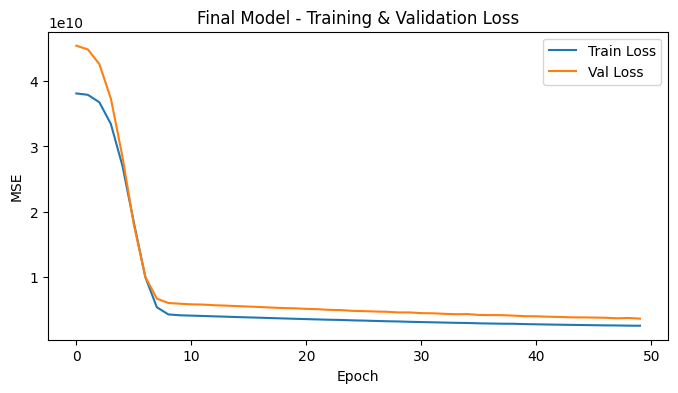

In [ ]:
# 7) Plot the final model's training & validation loss curves

plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Final Model - Training & Validation Loss')
plt.legend()
plt.show()


both lines decrease --> the model is learning effectively

   - One line shows the training loss (how well the model fits the training data).
   - The other line shows the validation loss (how well the model performs on unseen data).

A significant gap between the training and validation losses may indicate overfitting.

# Evaluate Final Performance on Validation Set

In [ ]:
# 8) Evaluate final model performance (MSE / RMSE) on the validation set

final_model.eval()
val_mse = 0.0
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        preds = final_model(batch_x).squeeze()
        loss  = criterion(preds, batch_y)
        val_mse += loss.item()

val_mse /= len(val_loader)
val_rmse = np.sqrt(val_mse)

print(f"\nFinal Model Validation MSE : {val_mse:.4f}")
print(f"Final Model Validation RMSE: {val_rmse:.4f}")



Final Model Validation MSE : 3670067744.0000
Final Model Validation RMSE: 60581.0840


- **Final Model Validation MSE: 3,670,067,744.0000**  
  This value represents the average of the squared differences between the predicted sale prices and the actual sale prices on the validation set. Because the errors are squared, the MSE tends to be a large number. It is less intuitive to interpret on its own because its units are the square of the target variable’s units (e.g., dollars²).

- **Final Model Validation RMSE: 60,581.0840**  
  The RMSE is the square root of the MSE, bringing the error metric back to the same units as the target variable (dollars, in this case). An RMSE of approximately 60,581 means that, on average, the model’s predictions deviate from the actual sale prices by about \$60,581.

    On average, the model's predicted sale price is off by roughly \$60,581 compared to the actual sale price.


# Generate Predictions on test.csv

In [ ]:
# 9) Generate Predictions
# We can't measure MSE on test.csv, as it lacks SalePrice, but can produce predictions.

test_data = pd.read_csv('test.csv')
print("\nColumns in test.csv:")
print(test_data.columns)

# Keep the same features, minus SalePrice (which doesn't exist)
test_data = test_data[['LotFrontage', 'LotArea', 'PoolArea',
                       'OverallQual','OverallCond','YearBuilt',
                       'GarageArea', 'YrSold']]

# Drop rows with missing data or choose an imputation strategy
test_data.dropna(inplace=True)
print("Test data shape after dropna:", test_data.shape)

# Scale using the same scaler
X_test = test_data.values
X_test_scaled = scaler.transform(X_test)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

# Inference
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_t).squeeze().numpy()

print("Predictions on test.csv (first 10):")
print(test_preds[:10])


Columns in test.csv:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

## **Summary of the Notebook**

1. **Data Loading and Preprocessing**  
   - **Import Libraries**: We load PyTorch, NumPy, Pandas, and other necessary libraries.  
   - **Load `train.csv`**: We select relevant numeric columns (e.g., `LotFrontage`, `LotArea`, `PoolArea`, `OverallQual`, etc.) and drop missing values.  
   - **Train/Validation Split**: We split the dataset into an 80% train set and a 20% validation set to track performance and avoid overfitting.  
   - **Scaling**: We use `MinMaxScaler` on the training set, then apply it to the validation set.

2. **PyTorch Dataset & DataLoader**  
   - We convert NumPy arrays into PyTorch tensors and wrap them in `TensorDataset`s.  
   - We create `DataLoader`s for both train and validation splits, enabling mini-batch processing.

3. **Neural Network Architecture**  
   - A simple MLP with 2 hidden layers (e.g., **64** and **32** units).  
   - Activation function: **ReLU**.  
   - Final output layer: single neuron for regression.

4. **Training & Validation Loop**  
   - **Loss Function**: Mean Squared Error (MSE) for regression.  
   - **Optimizer**: `Adam` (learning rate 0.01 by default).  
   - We track both **training loss** and **validation loss** for each epoch.  
   - This helps us monitor if the model starts overfitting (training loss goes down but validation loss goes up).

5. **Hyperparameter Tuning**  
   - An **optional** simple grid search snippet is included.  
   - It loops over a few choices for hidden layer sizes and learning rates.  
   - Records validation loss for each combination to find a best configuration.

6. **Final Evaluation**  
   - We compute **MSE** and **RMSE** on the validation set.  
   - This internal evaluation helps gauge real-world performance.

7. **Inference on `test.csv`**  
   - We load `test.csv` (which lacks `SalePrice`).  
   - We apply the same **MinMaxScaler** (fitted on training data).  
   - We feed the scaled test data into the final model, generating predictions.  
   - These predictions can be used for submission to Kaggle or further external evaluation.

**Key Takeaways**  
- This notebook demonstrates **end-to-end** training of an MLP in PyTorch:  
  1. **Data preprocessing** (filter columns, drop missing, scale).  
  2. **Train/Validation Split** (monitor overfitting).  
  3. **Defining and training** a neural network (2 hidden layers, ReLU).  
  4. **Hyperparameter tuning** snippet (optional).  
  5. **Final model evaluation** on the validation set and **prediction** on test data.  

- By **incorporating a validation set**, we ensure our model generalizes and avoid relying on Kaggle’s hidden labels alone.  
- This approach addresses common assignment objectives: feature engineering, data preprocessing, building/training a neural network, hyperparameter experimentation, and evaluation.
